In [ ]:
import pickle
import numpy as np

from sklearn.metrics import roc_auc_score, confusion_matrix

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [ ]:
with open('/content/drive/MyDrive/datasets/ps_split_data_dict.pickle', 'rb') as file:
    data_dict = pickle.load(file)

In [ ]:
y_train, y_val, y_holdout = data_dict['y_train'], data_dict['y_val'], data_dict['y_holdout']

In [ ]:
with open('/content/drive/MyDrive/datasets/ps_split_data_dict_25.pickle', 'rb') as file:
    data_dict_25 = pickle.load(file)

In [ ]:
X_train_25, X_val_25, X_holdout_25 = data_dict_25['X_train_25'], data_dict_25['X_val_25'], data_dict_25['X_holdout_25']

In [ ]:
xgb = XGBClassifier( 
                    n_estimators=30000,
                    max_depth=4,
                    objective='binary:logistic', 
                    learning_rate=.05, 
                    subsample=0.8,
                    min_child_weight=3
                    )

eval_set=[(X_train_25,y_train),(X_val_25,y_val)]
xgb.fit( 
        X_train_25, y_train, 
        eval_set=eval_set,
        eval_metric='auc',
        early_stopping_rounds=50,
        verbose=False
        )
auc = roc_auc_score(y_val, xgb.predict_proba(X_val_25)[:,1])
print(f"ROC AUC: {auc:.3f}\n")

ROC AUC: 0.645



In [ ]:
roc_auc_score(y_holdout, xgb.predict_proba(X_holdout_25)[:,1])

0.6413217140352176

In [ ]:
with open('/content/drive/MyDrive/datasets/xgb.pickle', 'wb') as file:
    pickle.dump(xgb, file)

In [ ]:
%run /content/drive/MyDrive/Colab\ Notebooks/common_functions.ipynb

In [ ]:
eval_gini(y_val, xgb.predict_proba(X_val_25)[:,1])

0.28905424495694254

In [ ]:
eval_gini(y_holdout, xgb.predict_proba(X_holdout_25)[:,1])

0.28264345166362126

Best F1 score 0.123 at prob decision threshold >= 0.059


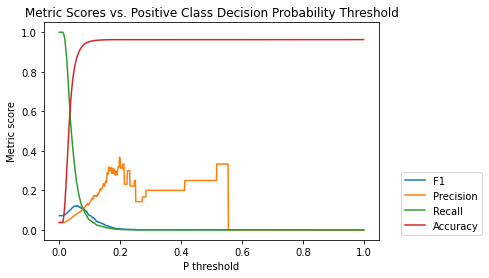

In [ ]:
threshold_diagram(X_holdout_25, y_holdout, xgb)

In [ ]:
y_pred_holdout = (xgb.predict_proba(X_holdout_25)[:,1] >= 0.032)

Percent claims in predicted no claim group: 2.39% 
Percent claims in predicted claim group: 5.11% 

Av payout per low risk member: $167.43 
Av payout per high risk member: $358.03 

Total Policies: 59522.00 
Total Claims: 2219.00 
Overall Percent claims 3.73%




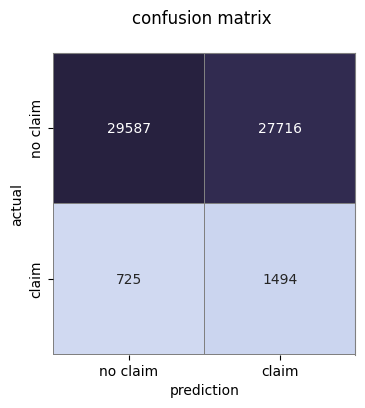

In [ ]:
confusion_diagram_simple(y_holdout, y_pred_holdout)

In [ ]:
low_risk_policy_price = 199
high_risk_policy_markup = 10
fixed_cost_per_policyholder = 25

def profit_function(model, X, y, p_threshold):
  y_pred1 = (model.predict_proba(X)[:,1] >= p_threshold)
  confusion = confusion_matrix(y, y_pred1)

  payout = np.sum(confusion[1]) * 7000
  low_risk_count = (confusion[0][0] + confusion[1][0])
  high_risk_count = (confusion[0][1] + confusion[1][1])
  payout_per_low_risk_member = confusion[1][0] * 7000 / low_risk_count

  profit_low_risk = (low_risk_policy_price - payout_per_low_risk_member - \
                     fixed_cost_per_policyholder) * low_risk_count
  profit_high_risk = high_risk_count * high_risk_policy_markup 

  total_profit = profit_low_risk + profit_high_risk

  return total_profit                

In [ ]:
profit_function(xgb, X_holdout_25, y_holdout, 0.023)

1152956.0

Highest total profit $1143820 at prob decision threshold >= 0.023
Profit per policy $19.22


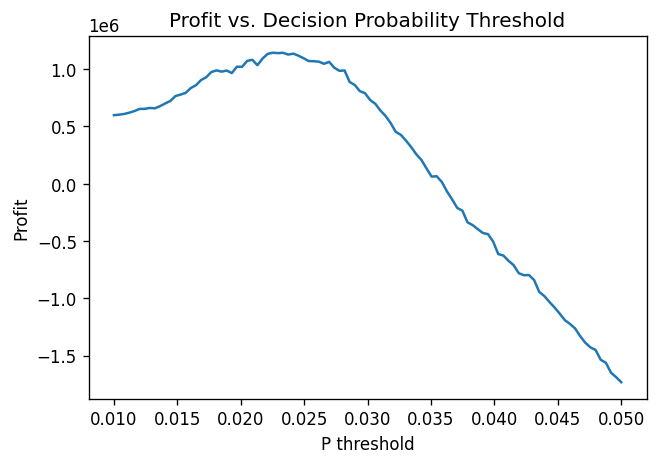

In [ ]:
thresh_ps = np.linspace(0.01,0.05,100)
profits = []
for p in thresh_ps:
  profit = profit_function(xgb, X_holdout_25, y_holdout, p)
  profits.append(profit)

plt.figure(dpi=120)
plt.plot(thresh_ps, profits)

plt.title('Profit vs. Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('Profit')

best_profit = np.max(profits) 
best_thresh_p = thresh_ps[np.argmax(profits)]

print('Highest total profit $%.0f at prob decision threshold >= %.3f' 
        % (best_profit, best_thresh_p))

print('Profit per policy $%.2f' 
        % (best_profit / y_holdout.shape[0]))

Percent claims in predicted no claim group: 1.72% 
Percent claims in predicted claim group: 4.27% 

Av payout per low risk member: $120.63 
Av payout per high risk member: $298.84 

Total Policies: 59522.00 
Total Claims: 2219.00 
Overall Percent claims 3.73%




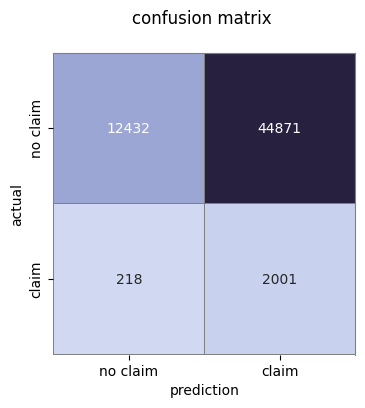

In [ ]:
y_pred_holdout2 = (xgb.predict_proba(X_holdout_25)[:,1] >= best_thresh_p)
confusion_diagram_simple(y_holdout, y_pred_holdout2)

In [ ]:
def confusion_diagram_with_stats(y_test, y_pred):
  confusion = confusion_matrix(y_test, y_pred)

  no_claim_pred_percent = confusion[1][0] / (confusion[0][0] + confusion[1][0]) * 100
  claim_pred_percent = confusion[1][1] / (confusion[0][1] + confusion[1][1]) * 100

  payout_per_low_risk_member = confusion[1][0] * 7000 / (confusion[0][0] + confusion[1][0])
  payout_per_high_risk_member = confusion[1][1] * 7000 / (confusion[0][1] + confusion[1][1])

  label_low = f'low risk group \n\n claims:  {no_claim_pred_percent:.2f}%        \n\n av. payout: ${payout_per_low_risk_member:.2f}'
  label_high = f'higher risk group \n\n claims:  {claim_pred_percent:.2f}%        \n\n av. payout: ${payout_per_high_risk_member:.2f}'

  plt.figure(dpi=100)
  palette = sns.color_palette("ch:start=0.1,rot=-0.1", as_cmap=True)
  ax = sns.heatmap(confusion, cmap=palette, annot=True, square=True, fmt='d', cbar=False, linewidths=0.1, linecolor='grey',
            xticklabels=[label_low, label_high],
            yticklabels=['no claim', 'claim']);
  ax.spines['top'].set_color('grey')
  ax.spines['top'].set_visible(True) 
  ax.spines['right'].set_color('grey')
  ax.spines['right'].set_visible(True) 
  ax.spines['bottom'].set_color('grey')
  ax.spines['bottom'].set_visible(True) 

  plt.ylabel('actual')
  plt.title('confusion matrix \n')

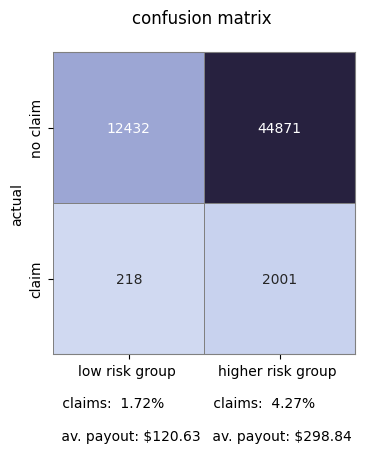

In [ ]:
confusion_diagram_with_stats(y_holdout, y_pred_holdout2)